In [3]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os
from pydataset import data

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import acquire
import env

#import prepare

import graphviz
from graphviz import Graph

Project Objectives

Document code, process (data acquistion, preparation, exploratory data analysis and statistical testing, modeling, and model evaluation), findings, and key takeaways in a Jupyter Notebook report.

Create modules (acquire.py, prepare.py) that make your process repeateable.

Construct a model to predict customer churn using classification techniques.

In [6]:
#acquire the data

df = pd.read_sql('''SELECT *
FROM customers
JOIN contract_types USING(contract_type_id)
JOIN internet_service_types USING(internet_service_type_id)
JOIN payment_types USING(payment_type_id);''', acquire.get_connection("telco_churn"))

In [7]:
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [ ]:
################################################################ PREPARE

In [9]:
#investigate the data from all angles and prepare
df.shape

(7043, 24)

In [10]:
df.describe()

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2.315633,1.872923,1.690473,0.162147,32.371149,64.761692
std,1.148907,0.737796,0.833755,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,2.000000,1.000000,0.000000,29.000000,70.350000
75%,3.000000,2.000000,2.000000,0.000000,55.000000,89.850000
max,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000


**What are some possible drivers of churn?**
Is a high monthly bill a driver of churn?
Do new customers with less tenure drive churn?
Does subscription to fiber optics drive churn?
Do customers with no partner or dependents churn more?
Do senior citizens churn more?
Does payment type effect the churn rate?

In [12]:
#drop columns with id since I used those just to JOIN the data
df.drop(columns=['payment_type_id','internet_service_type_id','contract_type_id'],inplace=True)

In [13]:
#make sure they are gone
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,Yes,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,0017-DINOC,Male,0,No,No,54,No,No phone service,Yes,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,0019-GFNTW,Female,0,No,No,56,No,No phone service,Yes,Yes,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,0056-EPFBG,Male,0,Yes,Yes,20,No,No phone service,Yes,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,0078-XZMHT,Male,0,Yes,No,72,Yes,Yes,No,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [16]:
#make target column binary
df.churn.replace(to_replace=['yes','no'],value=[1,0], inplace=True)

In [18]:
#drop customer_id since I have no use for it
df.drop(columns=['customer_id'], inplace=True)

In [19]:
#check to see that the target is binary and the id column is gone
df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,Female,0,Yes,Yes,65,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,Male,0,No,No,54,No,No phone service,Yes,No,No,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,Female,0,No,No,56,No,No phone service,Yes,Yes,Yes,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,Male,0,Yes,Yes,20,No,No phone service,Yes,No,Yes,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,Male,0,Yes,No,72,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [22]:
#drop all additional services since I am not interested in exploring
df.drop(columns=['online_security','online_backup','device_protection','tech_support','streaming_tv','streaming_movies'],inplace=True)

In [23]:
#make sure they are actually gone
df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,Female,0,Yes,Yes,65,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,Male,0,No,No,54,No,No phone service,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,Female,0,No,No,56,No,No phone service,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,Male,0,Yes,Yes,20,No,No phone service,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,Male,0,Yes,No,72,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [ ]:
############################################################ EXPLORE

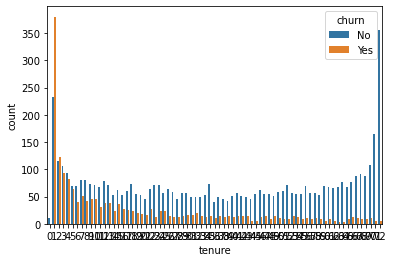

In [30]:
sns.countplot(data=df, x='tenure', hue='churn')
plt.show()

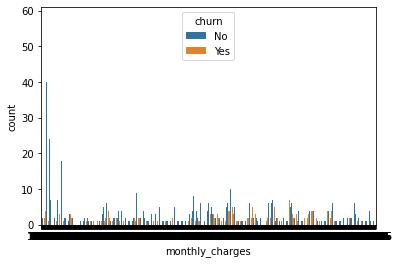

In [29]:
sns.countplot(data=df, x='monthly_charges', hue='churn')

plt.show()

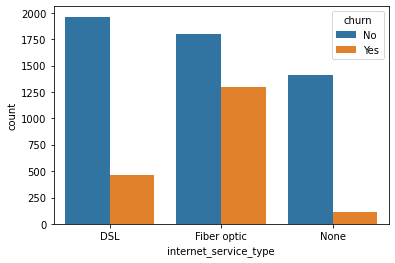

In [31]:
sns.countplot(data=df, x='internet_service_type', hue='churn')
plt.show()

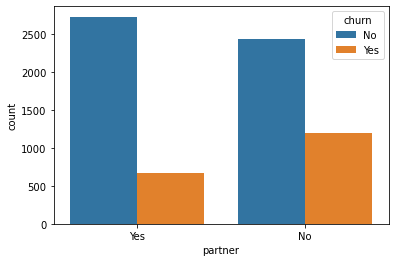

In [33]:
sns.countplot(data=df, x='partner',hue='churn')
plt.show()

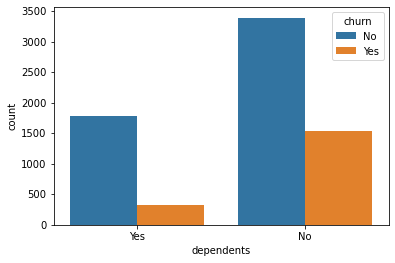

In [34]:
sns.countplot(data=df, x='dependents', hue='churn')
plt.show()

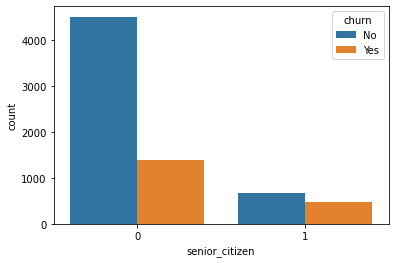

In [35]:
sns.countplot(data=df, x='senior_citizen', hue='churn')
plt.show()

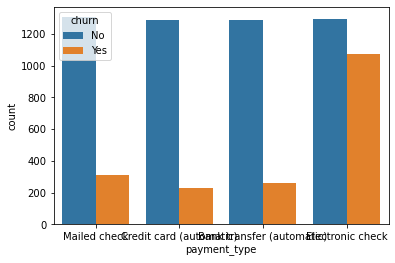

In [36]:
sns.countplot(data=df, x='payment_type', hue='churn')
plt.show()